In [72]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import sympy as sy
np.set_printoptions(precision=4)

In [73]:
#%matplotlib inline
def pltAttr(x='', y='', title=None, legend='best', save=None):
    plt.tight_layout()
    if legend is not None:
        plt.legend(loc=legend)
    plt.xlabel(x)
    plt.ylabel(y)
    if title is not None:
        plt.title(title)
    if save is not None:
        plt.savefig(save)

We define the surface here under the variable f

In [74]:
# global variables
g = 9.81
min_u = -1
max_u = 1
lambda_ = 0

#surface
x = sy.symbols('x') 
f = 0 # -sy.cos(x/2)

fp = sy.diff(f)
norm = 1 / sy.sqrt(1+fp**2)
normp = sy.diff(norm)
fp_norm = fp* norm
fp_normp = sy.diff(fp_norm)

f_lam = sy.lambdify(x, f)
fp_lam = sy.lambdify(x, fp)
normp_lam = sy.lambdify(x, normp)
fp_normp_lam = sy.lambdify(x, fp_normp)

Assume WLOG that we're trying to get x to go to 0. Makes things a bit simpler later.

In [90]:
#inital conditions and time
t0 = 0
tf = 8
x0 = -10
v0 = 0

In [91]:
# define state equations
def ode(y,t):
    x = y[0]
    v = y[1]
    p1 = y[2]
    p2 = y[3]
    
    #calculate various things
    fp_x = fp_lam(x)
    normp_x = normp_lam(x)
    fp_normp_x = fp_normp_lam(x)
    u = min(max(min_u, p2 / (2*(1-lambda_))), max_u)
#     u = p2 / (2*(1-lambda_))

    #find vdot and pdot
    xdot = v / np.sqrt(1 + fp_x**2)
    vdot = u - g*fp_x / np.sqrt(1 + fp_x**2)
    pd1 = -p1*v*normp_x + p2*g*fp_normp_x
    pd2 = -p1/np.sqrt(1+fp_x**2)
    
    return np.array([xdot, vdot, pd1, pd2])

In [92]:
#this is the function we want to find 0's of.
#we put in initial conditions for p1 and p2, and get out final condition on x and v
#we want to find which initial conditions for p1 and p2 gives out 0s for x and v
def func(p):
    return odeint(ode, np.array([x0, v0, p[0], p[1]]), [t0,tf], atol=1e-10)[1,0:2]

def find_zero(f,p0,Df,maxI):
    f_p1 = np.inf
    i = 0
    while np.linalg.norm(f_p1) > 10**-6 and i < maxI:
        #compute solution
        f_p0 = f(p0)

        #update guess
        p1 = p0 - np.linalg.inv(Df)@f_p0
        
        #update derivative
        f_p1 = f(p1)
        s = p1-p0
        y = f_p1 - f_p0
        Df = Df + np.outer(y-Df@s, s) / s@s
        
        #update values
#         print(f_p0, p0)
        p0 = p1
        i = i+1
        
    if i == maxI:
        print("t not found")
    return p1

#intial guess
p0 = np.array([0.5, 1])
#use finite difference to estimate derivative
Df = np.zeros((2,2))
h = 1e-4
#d/dp1
Df[:,0] = (func(p0 + np.array([h,0])) - func(p0 - np.array([h,0]))) / (2*h)
#d/dp2
Df[:,1] = (func(p0 + np.array([0,h])) - func(p0 - np.array([0,h]))) / (2*h)
print(Df)

p0 = find_zero(func, p0, Df, 100)
print(func(p0), p0)
t = np.linspace(t0, tf, 100)
sol = odeint(ode, np.array([x0, v0, p0[0], p0[1]]), t, atol=1e-10)

[[-35.9994  15.0005]
 [ -8.9999   3.0001]]
[-6.5527e-07 -6.4084e-07] [0.4688 1.875 ]


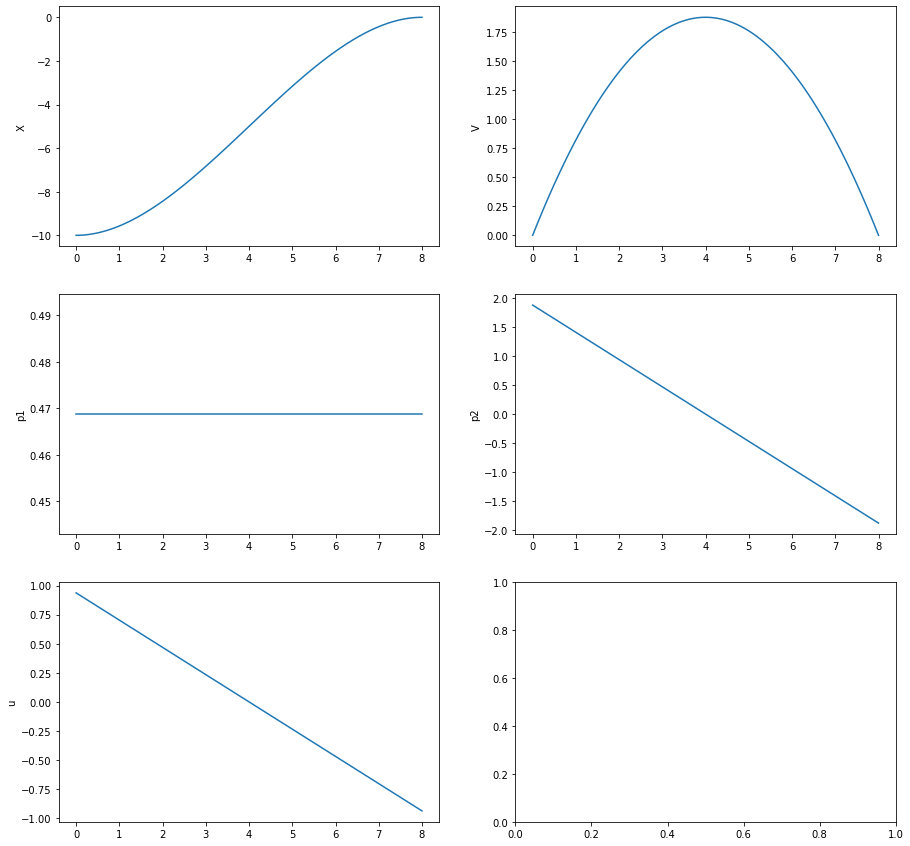

In [93]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
ax[0, 0].plot(t, sol[:,0])
ax[0, 0].set_ylabel('X')
ax[0, 1].plot(t, sol[:,1])
ax[0, 1].set_ylabel('V')
ax[1, 0].plot(t, sol[:,2])
ax[1, 0].set_ylabel('p1')
ax[1, 1].plot(t, sol[:,3])
ax[1, 1].set_ylabel('p2')

ones = np.ones_like(sol[:,3])
ax[2,0].plot(t, np.minimum(np.maximum(ones*min_u, sol[:,3] / (2*(1-lambda_))), ones*max_u))
ax[2,0].set_ylabel('u')
plt.show()
